# Neural Networks with PyTorch 🧠🧠

Now that we have learned some theory and code-free practical intuition about neural networks as well as the basics of data manipulation with PyTorch, it is time to start building models ourselves using its deep learning module: `torch.nn`!

## What will you learn in this course?

This course will focus on building our first neural networks using Python code with the help of PyTorch.

* The `torch.nn` Module
  * Fully Connected (Linear) layer
  * BatchNormalization layer
  * Dropout layer
* Activation functions  
* Regularizers
* The `torch.nn.Module` class
  * The Sequential class
  * Defining custom models using `nn.Module`
  * Making a forward pass with the model
  * Manipulations on model objects
    * Extract outputs from a layer
    * Extract weights with `.parameters()`
    * Manually change weights
* Prepare the model for training
  * Loss functions
  * Optimizers
    * ADAM
    * Learning rate scheduling
  * Training loop
* Model training
* Making predictions
* Saving and loading models
  * Checkpoints
  * Save 
  * Load

Everything in PyTorch is organized using `torch.nn`, and each building block of a deep learning model will be defined using objects from this module. Let's explore them one by one!

## The `nn.Module` Class 🚀🚀

You can learn everything in the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html). This module contains different types of neural network layers that can be added to model architectures.

### The Fully Connected (Linear) Layer 💃

The `Linear` layer in PyTorch builds a fully connected neuron layer.

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/Dense2.png" />

This layer's neurons multiply each input value with a parameter, computes the sum, adds a bias, before applying an activation function. Let's see how to use it:

In [15]:
# !pip install torch torchinfo torchviz

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

linear = nn.Linear(in_features=3, out_features=2)
# in_features: number of input features
# out_features: number of output neurons

# Example forward pass
x = torch.randn(1, 3)  # Batch size 1, 3 input features
output = linear(x)
print(output)

tensor([[0.7261, 0.1195]], grad_fn=<AddmmBackward0>)


### BatchNormalization Layer 📊

Batch normalization is a special layer whose role is not to learn patterns in the data but rather, as its name indicates, to normalize the output of the preceding layer so that its values are scaled across one batch of data.

<Note type="tip" title="Why use BatchNormalisation">
Why use BatchNormalisation? Remember when we were normalising quantitative variables in supervised ML? We were saying that given most models are non-linear, they do not treat numerical values the same depending on the scale (e.g. for logisic regression $ \sigma(1)-\sigma(0) \approx 0.23 $ but $ \sigma(101) - \sigma(100) \approx 0 $).

This leads to differences in treatment for variables in the model depending on scale, not information. (e.g. in the case of regularisation it is very clear: regularisation penalizes parameters more and more as they move away from zero, which risks penalizing low scale variables that are generally associated with high parameters more than high scale variables that are generally associated with proportionately lower parameters)

In a deep learning model, each layer produces new features that get fed to other layers, if these new features vary in scale, we run into a similar pitfall. BatchNormalisation is useful to counteract that.
</Note>

<Note type="tip" title="BatchNormalisation vs ADAM">
We've mentionned during our gradient descent lesson that the ADAM algorithm helps convergence by adapting the learning for each parameter in the model.

Although this may seen redundant with using BatchNormalization because both techniques aim at compensating scale discrepencies in the model, used in conjunction both these techniques participate in improving training stability (gradients direction is not erratic) and convergence speed (it takes less iteration to reach lower loss values).
</Note>

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/BatchNorm3.png" />

As shown in the figure, each of the outputs from the previous layer is normalized independently so each of them has a mean of 0 and a standard deviation of 1.

Each new batch passing forward through the network will be normalized accordingly.

Now let's see how we can create such a layer with PyTorch!

In [17]:
bn = nn.BatchNorm1d(num_features=2)
# num_features: Number of input features to normalize

# Example forward pass
x = torch.randn(5, 2)  # Batch size 5, 2 features
output = bn(x)
print(output)

tensor([[-0.9047, -1.8772],
        [-0.0157,  0.0630],
        [ 0.2427,  0.1105],
        [-1.0563,  0.9175],
        [ 1.7340,  0.7862]], grad_fn=<NativeBatchNormBackward0>)


One last thing you need to know about batch normalization: since we are basing the normalization on batches that the network sees throughout the training, which change all the time, this layer will work differently during training and inference.

During inference, this layer will use a moving average of the mean and standard deviation calculated during the training process so that the normalization parameters are adapted to all the training data as best as possible. You won't have to worry much about this in practice, but feel free to check the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more details on how this layer works during inference.


### DropOut ♻️

The DropOut layer is also not a trainable layer; it does not help the model detect patterns in the data but rather helps prevent overfitting.

It works in the following way: you can place the DropOut layer between two other layers, and at each batch of data passing forward in the network, it will **randomly** pick a portion of the outputs from the previous layer and set them to 0. This means the next layer will only be able to see a portion of the information that the DropOut layer has not touched, and this available portion changes at every next batch!

<Note typt="tip" title="Why use DropOut?">
Evidence of the <a href="https://full-stack-assets.s3.eu-west-3.amazonaws.com/M08-deep-learning/drop_out_in_conv_net.pdf">regularization effect of dropout exist</a>. However the effect depends on the drop out rate and should be tuned using hyperparameter tuning techniques such as grid search (which require a lot of computing power for deep learning tasks)

1️⃣ Lower Layers (Bottom of the Network)
✅ Preserve essential features – The initial layers capture low-level features (e.g., edges in images, simple patterns in tabular data). Applying dropout too early may remove critical information.
✅ Helps in deep networks – In very deep networks, a small amount of dropout (e.g., 0.1–0.3) in lower layers can improve generalization.
❌ Risk of information loss – High dropout early on can prevent the network from learning robust feature representations.

Best Practice: If applying dropout to bottom layers, use a lower dropout rate (e.g., 0.1–0.3).

2️⃣ Higher Layers (Top of the Network)
✅ Breaks co-adaptation – Dropout works best in fully connected layers near the output, where neurons are more specialized and prone to overfitting.
✅ More abstract representations – Later layers learn high-level concepts, and dropout ensures these representations are not overly dependent on specific neurons.
✅ Higher dropout rates are effective – Dropout values around 0.3–0.5 in the top layers are often effective in preventing overfitting.

Best Practice: Use higher dropout (0.3–0.5) in the final hidden layers before the output layer.
</Note>

<img src="https://full-stack-assets.s3.eu-west-3.amazonaws.com/images/M08-DeepLearning/DropOut3.png" />

Let's now discover how to create a DropOut layer with PyTorch!


In [18]:
import torch.nn as nn

do = nn.Dropout(p=0.2)
# The important parameter when instantiating the DropOut layer is p, it 
# indicates the proportion of outputs from the previous layer that will randomly
# be set to zero at each batch passing forward.
# The closer to one, the higher proportion of outputs set to zero and harder
# it will be for the model to overfit, but also to train.
# The closer to zero, the lower proportion of outputs set to zero and the easier
# it will be for the model to train, but also overfit.


## Activation functions 💡💡

An exhaustive list of all pre-implemented activation functions in PyTorch may be found in the [official documentation](https://pytorch.org/docs/stable/nn.functional.html).

Activation functions can be used in different forms in PyTorch. They can be added as an argument of layer objects and therefore take the form of functions from `torch.nn.functional`:


In [19]:
import torch
import torch.nn.functional as F
import numpy as np
import plotly.graph_objects as go

x = torch.linspace(-5, 5, 500)

fig = go.Figure(data=[
    go.Scatter(x=x.numpy(), y=F.relu(x).numpy(), mode="lines", name="ReLU"),
    go.Scatter(x=x.numpy(), y=F.sigmoid(x).numpy(), mode="lines", name="Sigmoid"),
    go.Scatter(x=x.numpy(), y=F.tanh(x).numpy(), mode="lines", name="TanH"),
])

fig.show()

# Another activation function we haven't yet talked about but will be useful
# for multi-class classification problems is "softmax", which we will explore in practice.


Another way of adding activation functions in a network is to use their layer form from `torch.nn`:

In [20]:
import torch.nn as nn

relu = nn.ReLU()
tanh = nn.Tanh()
sigmoid = nn.Sigmoid()

## Loss fucntions and Regularization 📐📐

Loss functions help measure a model's prediction errors, and gets optimized through parameter fitting during training.

In Pytorch, regularization is set up at the Optimizer level.

In [21]:
import torch.nn as nn
# In order to include these in a specific layer, we use weight decay in the optimizer:
dense_L2 = nn.Linear(in_features=2, out_features=4)
optimizer = torch.optim.Adam(dense_L2.parameters(), lr=0.01, weight_decay=0.01)  # L2 regularization



## The Model class 🔮🔮

The class `nn.Module` represents objects containing the neural network so that we can easily train them and make predictions, similar to how we use models in scikit-learn. The main advantage here is the flexibility PyTorch provides in building different architectures.

### Sequential models ✈️

The easiest way to build a neural network model in PyTorch is by using the `nn.Sequential` class. This allows us to create neural network models with layers stacked on top of each other, where the input travels from the bottom layer all the way to the top layer sequentially.

Let's see how we can build a simple neural network model using code:

In [22]:
import torch
from torchinfo import summary

# Creating a sequential model
sequential_model = nn.Sequential(
    nn.Linear(2, 8),  # Input layer with 2 features and 8 neurons
    nn.ReLU(),
    nn.BatchNorm1d(8),  # Batch Normalization
    nn.Linear(8, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

print(sequential_model)
# Print model summary
summary(sequential_model, input_size=(1, 2))  # (batch_size, input_features)

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=8, out_features=4, bias=True)
  (4): ReLU()
  (5): Linear(in_features=4, out_features=1, bias=True)
  (6): Sigmoid()
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 1]                    --
├─Linear: 1-1                            [1, 8]                    24
├─ReLU: 1-2                              [1, 8]                    --
├─BatchNorm1d: 1-3                       [1, 8]                    16
├─Linear: 1-4                            [1, 4]                    36
├─ReLU: 1-5                              [1, 4]                    --
├─Linear: 1-6                            [1, 1]                    5
├─Sigmoid: 1-7                           [1, 1]                    --
Total params: 81
Trainable params: 81
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Building non-sequential Models 🚀

In case you want to create more complicated architectures, you will need to use the `torch.nn.Module` class, which allows you to define custom neural networks layer by layer. Let's see how this works with PyTorch!

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense1 = nn.Linear(2, 8)
        self.bn = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(0.2)
        self.dense2a = nn.Linear(8, 4)
        self.dense2b = nn.Linear(8, 4)
        self.dense2c = nn.Linear(4, 4)
        self.dense3 = nn.Linear(8, 1)  # Final layer

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = self.bn(x)
        x = self.dropout(x)
        xa = F.relu(self.dense2a(x))
        xb = F.relu(self.dense2b(x))
        xc = F.relu(self.dense2c(xb))
        x = torch.cat([xa, xc], dim=1)
        x = torch.sigmoid(self.dense3(x))
        return x

model = CustomModel()
print(model)

# Print model summary
summary(model, input_size=(1, 2))  # (batch_size, input_features)


CustomModel(
  (dense1): Linear(in_features=2, out_features=8, bias=True)
  (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2a): Linear(in_features=8, out_features=4, bias=True)
  (dense2b): Linear(in_features=8, out_features=4, bias=True)
  (dense2c): Linear(in_features=4, out_features=4, bias=True)
  (dense3): Linear(in_features=8, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
CustomModel                              [1, 1]                    --
├─Linear: 1-1                            [1, 8]                    24
├─BatchNorm1d: 1-2                       [1, 8]                    16
├─Dropout: 1-3                           [1, 8]                    --
├─Linear: 1-4                            [1, 4]                    36
├─Linear: 1-5                            [1, 4]                    36
├─Linear: 1-6                            [1, 4]                    20
├─Linear: 1-7                            [1, 1]                    9
Total params: 141
Trainable params: 141
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


This technique is extremely useful because it allows us to deviate from a strictly sequential architecture and build more flexible models.

#### Visualize models

If you want a graph-based visualization of your model's operations, torchviz can generate a computational graph.

<Note type="warning" title="install graphviz">
You'll need to install grpahviz in order to use the visualizing tools from pytorch.

#### **For Linux/macOS:**
```bash
sudo apt install graphviz  # Ubuntu/Debian
brew install graphviz      # macOS (Homebrew)
```

#### **For Windows:**
1. Download and install Graphviz from the official site:  
   👉 **[Graphviz Download](https://graphviz.gitlab.io/download/)**  
2. During installation, select **"Add Graphviz to system PATH"**.
3. Restart your terminal or IDE (VSCode, Jupyter, etc.).
4. Verify installation by running:
   ```bash
   dot -V
   ```
   If it prints the Graphviz version, it’s correctly installed.

</Note>

In [24]:
from torchviz import make_dot

# Create a dummy input tensor
dummy_input = torch.randn(10, 2)

# Get the model output
output = model(dummy_input)

# Create and display the computational graph
make_dot(output, params=dict(model.named_parameters())).render("model_architecture", format="png")


'model_architecture.png'



### The last layer 🔚

Before moving on, it's essential to choose the correct final layer for the model based on the task:
- For **regression problems**, use a `Linear` layer without an activation function.
- For **binary classification**, use a `Linear` layer followed by a `Sigmoid` activation.
- For **multi-class classification**, use a `Linear` layer followed by a `Softmax` activation.

### Make a forward pass with the model ➡️

Now that we know how to build models in PyTorch, let's transform inputs into outputs:

In [25]:
# Create sample input data
input_data = torch.tensor([[1.0, 2.0],[3.0, 4.0]])  # Shape must match input layer

# Forward pass
output = model(input_data)
print("Model output:", output)

Model output: tensor([[0.5094],
        [0.4840]], grad_fn=<SigmoidBackward0>)


### Manipulations on model objects 👈

Now that we know how to build models and make a forward pass, let's explore some additional attributes and methods associated with PyTorch model objects.

#### Extract weights/parameters

Seeing model weights can help interpret what a deep learning model is doing internally. Let's retrieve the weights from our model:

In [26]:
# Print all model parameters
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

dense1.weight: torch.Size([8, 2])
dense1.bias: torch.Size([8])
bn.weight: torch.Size([8])
bn.bias: torch.Size([8])
dense2a.weight: torch.Size([4, 8])
dense2a.bias: torch.Size([4])
dense2b.weight: torch.Size([4, 8])
dense2b.bias: torch.Size([4])
dense2c.weight: torch.Size([4, 4])
dense2c.bias: torch.Size([4])
dense3.weight: torch.Size([1, 8])
dense3.bias: torch.Size([1])


#### Extract layer-specific content

We can also inspect specific layers in the model:

In [27]:
# Print all layer names
for layer in model.children():
    print(layer)

Linear(in_features=2, out_features=8, bias=True)
BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Dropout(p=0.2, inplace=False)
Linear(in_features=8, out_features=4, bias=True)
Linear(in_features=8, out_features=4, bias=True)
Linear(in_features=4, out_features=4, bias=True)
Linear(in_features=8, out_features=1, bias=True)


In [28]:
# Extract a specific layer and inspect its parameters
specific_layer = model.dense1
print("Layer weights:", specific_layer.weight)
print("Layer bias:", specific_layer.bias)

Layer weights: Parameter containing:
tensor([[-0.0895,  0.6141],
        [ 0.3563,  0.6640],
        [ 0.6534, -0.1427],
        [ 0.1384, -0.1188],
        [ 0.0309, -0.2819],
        [ 0.2216, -0.5450],
        [-0.6679, -0.0499],
        [-0.2036,  0.6495]], requires_grad=True)
Layer bias: Parameter containing:
tensor([-0.1801,  0.1925, -0.0848,  0.5637,  0.5456,  0.4550, -0.5523,  0.2976],
       requires_grad=True)


In [29]:
# Assign new values to layer parameters
with torch.no_grad():
    specific_layer.bias.fill_(1.0)  # Assigning bias values to 1
    specific_layer.weight.zero_()   # Setting all weights to zero

print("Updated bias:", specific_layer.bias)
print("Updated weights:", specific_layer.weight)

Updated bias: Parameter containing:
tensor([1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True)
Updated weights: Parameter containing:
tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], requires_grad=True)


In order to analize intermediate outputs of the model, you may build another model using the same layers as your original model.

This could help you visualize outputs from intermediate layers, study their activations etc...

In [30]:
# Extract the output of an intermediate layer
intermediate_model = nn.Sequential(model.dense1, model.bn, model.dropout)
intermediate_output = intermediate_model(input_data)
print("Intermediate output:", intermediate_output)

Intermediate output: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<MulBackward0>)


## Prepare the model for training 🏃🏃

We are almost ready to train our model, but we still need to choose the loss function, the optimization algorithm, and the learning rate. Let's see how to do all this using PyTorch!

### Loss functions 💰

PyTorch provides several built-in loss functions, which you can find in the [official documentation](https://pytorch.org/docs/stable/nn.html#loss-functions).

In [31]:
import torch.nn as nn

# MSE
# Ideal for most regression problems
mse = nn.MSELoss()
print("MSE:", mse(torch.tensor([[1.0]]), torch.tensor([[2.0]])))

# Binary Cross Entropy: - log(P(y=1))
# Ideal for binary classification problems
bce = nn.BCELoss()
print("Binary cross entropy:", bce(torch.tensor([[0.12]]), torch.tensor([[0.0]])))

# Categorical Cross Entropy
# Ideal for multi-class classification problems
# Non-sparse for one-hot encoded targets
cce = nn.CrossEntropyLoss()
print("Categorical cross entropy:", cce(torch.tensor([[0.2,0.1,0.15,0.55]]), torch.tensor([3])))

MSE: tensor(1.)
Binary cross entropy: tensor(0.1278)
Categorical cross entropy: tensor(1.1028)


### Optimizers 📈

Optimizers in PyTorch provide different variants of gradient descent. You can find more details in the [official documentation](https://pytorch.org/docs/stable/optim.html).

#### Adam

Adam is an adaptive optimization algorithm that adjusts the learning rate based on past gradients.


In [32]:
import torch.optim as optim

opt = optim.Adam(sequential_model.parameters(),lr=0.001)  # Define base learning rate

#### Learning rate schedules

In addition to choosing an optimizer, you can define a learning rate schedule. In this lecture, we will use `ExponentialLR`, which exponentially decreases the learning rate during training.

<Note type="tip" title="Why use decaying learning rate ?">
Deep Neural Network models often overfit their training data, sometimes very fast. After a few training attemps, you should get a better understanding of how your model trains, after how many steps does it overfit.
A decaying learning helps you slow down training as the model gets close to overfitting in order to achieve better peroformance. (Think golf, the closer you are from the target, the smaller distance you have to cross, the softer you'll hit the ball)
</Note>


In [33]:
from torch.optim.lr_scheduler import ExponentialLR

# Define optimizer
optimizer = optim.Adam(sequential_model.parameters(),lr=0.001)

# Define learning rate scheduler
scheduler = ExponentialLR(optimizer, gamma=0.96)

# Example of using the scheduler during training
for epoch in range(10):
    optimizer.step()
    scheduler.step()
    print(f"Epoch {epoch+1}, Learning Rate: {scheduler.get_last_lr()}")

Epoch 1, Learning Rate: [0.00096]
Epoch 2, Learning Rate: [0.0009216]
Epoch 3, Learning Rate: [0.0008847359999999999]
Epoch 4, Learning Rate: [0.0008493465599999999]
Epoch 5, Learning Rate: [0.0008153726975999999]
Epoch 6, Learning Rate: [0.0007827577896959998]
Epoch 7, Learning Rate: [0.0007514474781081598]
Epoch 8, Learning Rate: [0.0007213895789838333]
Epoch 9, Learning Rate: [0.00069253399582448]
Epoch 10, Learning Rate: [0.0006648326359915007]


## Model training 💦💦

The model training step is now straightforward. Let's show a full example with an easy dataset using PyTorch.

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=4, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=4, shuffle=True)

# Define the model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(8, 4)
        self.fc3 = nn.Linear(4, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=1)

model = NeuralNetwork(input_size=X.shape[1], num_classes=len(np.unique(y)))

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
        train_acc = correct / len(train_loader.dataset)
        
        model.eval()
        val_loss, correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
        val_acc = correct / len(val_loader.dataset)
        
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss / len(val_loader))
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    
    return history

history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


Epoch 1/10, Train Loss: 25.5450, Val Loss: 8.8353, Train Acc: 0.3000, Val Acc: 0.3333
Epoch 2/10, Train Loss: 24.5686, Val Loss: 7.8884, Train Acc: 0.3889, Val Acc: 0.6333
Epoch 3/10, Train Loss: 21.5593, Val Loss: 6.5438, Train Acc: 0.6222, Val Acc: 0.6667
Epoch 4/10, Train Loss: 19.9916, Val Loss: 6.4277, Train Acc: 0.6333, Val Acc: 0.6667
Epoch 5/10, Train Loss: 19.9318, Val Loss: 6.1046, Train Acc: 0.6222, Val Acc: 0.6667
Epoch 6/10, Train Loss: 21.2340, Val Loss: 5.8877, Train Acc: 0.5889, Val Acc: 0.7333
Epoch 7/10, Train Loss: 18.7297, Val Loss: 5.8268, Train Acc: 0.8444, Val Acc: 0.8667
Epoch 8/10, Train Loss: 17.5135, Val Loss: 5.4045, Train Acc: 0.8667, Val Acc: 0.9333
Epoch 9/10, Train Loss: 16.9924, Val Loss: 5.0792, Train Acc: 0.8667, Val Acc: 0.9333
Epoch 10/10, Train Loss: 17.8176, Val Loss: 4.8421, Train Acc: 0.8111, Val Acc: 1.0000


### Visualizing Training Progress

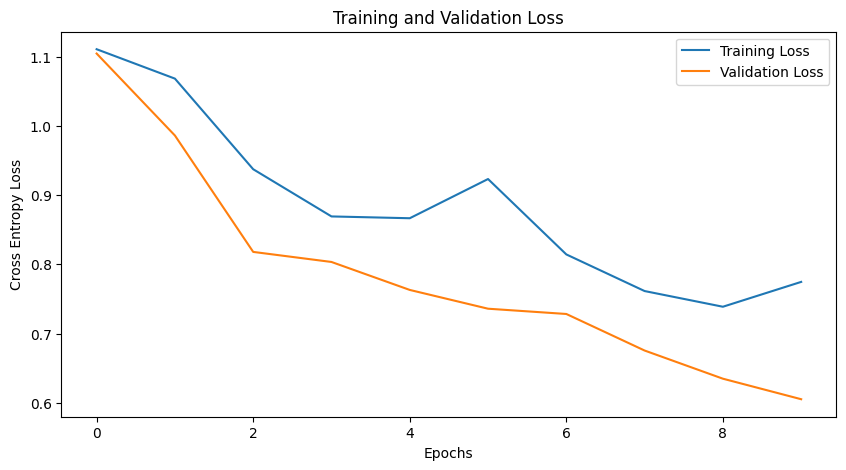

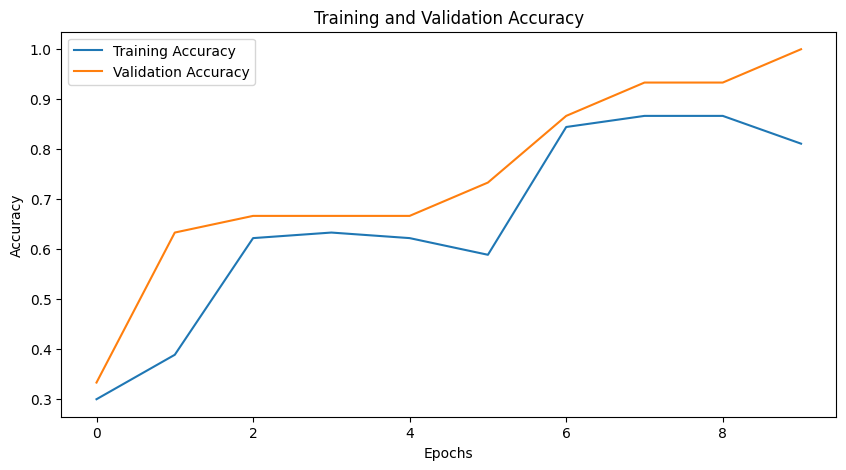

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['train_acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Making Predictions 🔮🔮


In [36]:
# Make predictions
model.eval()
test_inputs, test_labels = next(iter(test_loader))
with torch.no_grad():
    predictions = model(test_inputs)

# Convert predictions to class labels
predicted_classes = torch.argmax(predictions, axis=1)
print("Predicted classes:", predicted_classes)
print("Actual classes:", test_labels)

Predicted classes: tensor([0, 2, 1, 0])
Actual classes: tensor([0, 2, 1, 0])


## Load and Save models 💾💾

We have now learned almost all the basics of PyTorch, and you are almost ready to tackle many different problems using deep learning models! But before we let you practice, we will teach you one last and very useful set of skills: how to save your models to be able to use them later!

### Checkpoints ✔️

Checkpoints are versions of the model that we save directly during training. This is very useful because if the model starts overfitting after a while, we won't lose the intermediate versions and will be able to go back to a version of the model before it started overfitting! Isn't that great?

Let's learn how to do it with code!

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import os

# Sample Dataset (Iris)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
iris = load_iris()
X, y = iris.data, iris.target

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Create DataLoader
train_dataset = data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = data.TensorDataset(X_val_tensor, y_val_tensor)

train_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=8, shuffle=False)

# Define Model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, num_classes)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        return self.fc3(x)  # No softmax since CrossEntropyLoss applies it

# Initialize Model
model = NeuralNetwork(input_size=4, num_classes=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Directory for saving checkpoints
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Training Loop with Checkpoint Saving
num_epochs = 10

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss, correct = 0, 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(dim=1) == labels).sum().item()

    train_accuracy = correct / len(train_loader.dataset)

    # Save model checkpoint every epoch
    checkpoint_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': total_loss / len(train_loader),
    }, checkpoint_path)

    print(f"Epoch [{epoch}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Checkpoint saved: {checkpoint_path}")

print("Training complete! 🚀")


Epoch [1/10], Loss: 14.9725, Accuracy: 0.5167
Checkpoint saved: checkpoints/epoch_1.pth
Epoch [2/10], Loss: 12.4851, Accuracy: 0.7750
Checkpoint saved: checkpoints/epoch_2.pth
Epoch [3/10], Loss: 10.3065, Accuracy: 0.8083
Checkpoint saved: checkpoints/epoch_3.pth
Epoch [4/10], Loss: 8.4420, Accuracy: 0.8333
Checkpoint saved: checkpoints/epoch_4.pth
Epoch [5/10], Loss: 7.0508, Accuracy: 0.8333
Checkpoint saved: checkpoints/epoch_5.pth
Epoch [6/10], Loss: 6.0192, Accuracy: 0.8667
Checkpoint saved: checkpoints/epoch_6.pth
Epoch [7/10], Loss: 5.0868, Accuracy: 0.9000
Checkpoint saved: checkpoints/epoch_7.pth
Epoch [8/10], Loss: 4.3384, Accuracy: 0.9250
Checkpoint saved: checkpoints/epoch_8.pth
Epoch [9/10], Loss: 3.6932, Accuracy: 0.9500
Checkpoint saved: checkpoints/epoch_9.pth
Epoch [10/10], Loss: 3.1561, Accuracy: 0.9500
Checkpoint saved: checkpoints/epoch_10.pth
Training complete! 🚀


### Load 📀

And load it later, even in a different script.

In [38]:
restored_model = NeuralNetwork(input_size=4, num_classes=3)  # Ensure the same architecture
restored_model.load_state_dict(torch.load("checkpoints/epoch_10.pth", weights_only=True)["model_state_dict"])
restored_model.eval()

NeuralNetwork(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=32, out_features=3, bias=True)
)

That was a long demo, but you are now all equipped to tackle many different problems with PyTorch and deep neural network models. Now let's get to the exercises to start getting some practice!

## Resources 📚📚

* [An easy tutorial on the MNIST dataset](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)
* [PyTorch Datasets and DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
* [PyTorch Model Saving & Loading](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
* [Google Dataset Search](https://datasetsearch.research.google.com/)
